In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by((measurement.date).desc()).first()
most_recent_date

('2017-08-23')

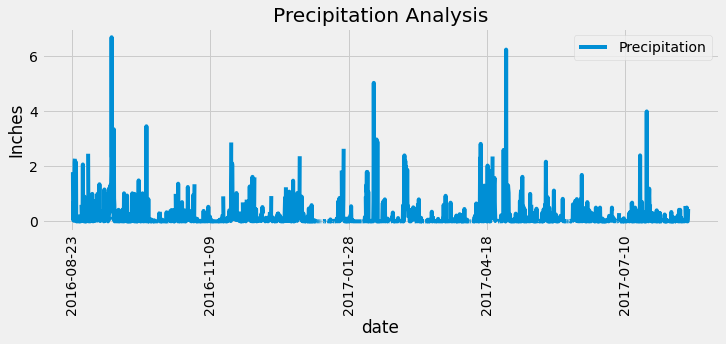

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by((measurement.date).desc()).first()
most_recent_date
# Calculate the date one year from the last date in data set.
one_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_date

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_date).all()
results
# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results)
results_df = results_df.set_index('date')
results_df = results_df.rename(columns={"prcp": "Precipitation"})

# Sort the dataframe by date
results_df = results_df.sort_values(by=['date'])
results_df

# Use Pandas Plotting with Matplotlib to plot the data

results_df.plot(title="Precipitation Analysis", rot=90, figsize=(10,5))

plt.tight_layout()
plt.ylabel("Inches")
plt.legend()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number station's in the dataset
station_count = session.query(func.count(station.station)).all()
station_count

[(9)]

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# List first row to find most active station number and count
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
most_active

('USC00519281', 2772)

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#lowest temperature
lowest_temp = session.query(measurement.station, func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
lowest_temp

[('USC00519281', 54.0)]

In [17]:
#highest temperature
highest_temp = session.query(measurement.station, func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
highest_temp

[('USC00519281', 85.0)]

In [18]:
#average temperature
avg_temp = session.query(measurement.station, func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
avg_temp

[('USC00519281', 71.66378066378067)]

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# design a query to find the last year of temperature observation data in data for the most active station id
most_recent_date = session.query(measurement.date).filter(measurement.station == 'USC00519281').order_by((measurement.date).desc()).first()
one_year_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
one_year_date

datetime.date(2016, 8, 18)

In [20]:
# query data to find last 12 months of temperature observation data
results_tobs = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= one_year_date).order_by(measurement.date).all()
results_tobs[:10]

[('2016-08-18', 80.0),
 ('2016-08-19', 79.0),
 ('2016-08-20', 81.0),
 ('2016-08-21', 79.0),
 ('2016-08-22', 78.0),
 ('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0)]

In [21]:
# put date and temperature results into two lists
dates = [result[0] for result in results_tobs]
temperatures = [int(result[1]) for result in results_tobs]
results = pd.DataFrame(results_tobs)
results = results.set_index('date')
results.head()

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


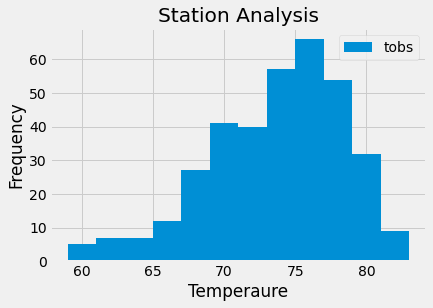

In [22]:
# plot results as a histogram
plt.hist(results, bins=12, label="tobs")
plt.title('Station Analysis')
plt.xlabel('Temperaure')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close session

In [23]:
# Close Session
session.close()

# Climate App

In [24]:
# import flask and jsonify
from flask import Flask, jsonify

In [25]:
# flask set up
app = Flask(__name__)

In [26]:
# homepage - llist all routes available
@app.route("/")
def welcome():
    return (
    f"Available Routes:<br/>"
    f"/api/v1.0/precipitation<br/>"
    f"/api/v1.0/stations<br/"
    f"/api/v1.0/tobs<br/"
    f"/api/v1.0/start<br/>"
    f"/api/v1.0/start/end"
)

In [27]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    results = session.query(measurement.date, measurement.prcp).all()
    
# create dictionary using date as key and prcp as value
    date_prcp = []
    for result in results:
        data = {}
        data['date'] = results[0]
        data['prcp'] = results[1]
        date_prcp.append(data)
        
    return jsonify(date_prcp)

In [28]:
# return a JSON list of stations from the dataset
@app.route("/api/v1.0/stations")
def stations():
    stations = session.query(station.station).all()

    return jsonify(stations)

In [29]:
# Return a JSON list of temperature observations (TOBS) for the previous year.
@app.route("/api/v1.0/tobs")
def tobs():
    results = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= dt.date(2016, 8, 18)).order_by(measurement.date).all()
    
    return jsonify(results)

In [30]:
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
@app.route("/api/v1.0/<start>")
def start(start = dt.date(2015, 8, 1)):
    results = session.query(measurement.tobs).filter(measurement.date >= dt.date(2015, 8, 1)).all()

    TMIN = min(results)
    TAVG = mean(results)
    TMAX = max(results)
    
    return jsonify(TMIN, TAVG, TMAX)

In [31]:
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.
@app.route("/api/v1.0/<start>/<end>")
def start_end(start = dt.date(2016, 8, 18), end = dt.date(2017, 8, 18)):
    results = session.query(measurement.tobs).filter(measurement.date >= dt.date(2016, 8, 18), measurement.date <= dt.date(2017, 8, 18)).all()
    
    TMIN = min(results)
    TAVG = mean(results)
    TMAX = max(results)
    
    return jsonify(TMIN, TAVG, TMAX)

In [32]:
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 48] Address already in use